# Interactive Deep Colorization and its Application for Image Compression DEMO (TF 1.X)

A modern port of https://github.com/praywj/Interactive-Deep-Colorization-and-Compression.

Paper: https://www.computer.org/csdl/journal/tg/5555/01/09186041/1mP2JjLRhDy

## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

## Merge Project (requires Google Drive Access!)

In [1]:
import sys
import os
# adjust path as required!

_BASE_PATH = ""
# google colab (create link of Paper_Sibiu to own drive first)
if 'google.colab' in str(get_ipython()):
    _BASE_PATH = "/content/drive/MyDrive/Paper_Sibiu/Interactive-Deep-Colorization-and-Compression-tf/"
    from google.colab import drive
    if not os.path.isdir('/content/drive'):
        drive.mount('/content/drive')
# local
else:
    _BASE_PATH = "~/Documents/ICDD/Interactive-Deep-Colorization-and-Compression-tf/"

sys.path.extend([_BASE_PATH])
os.chdir(_BASE_PATH)

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# %tensorflow_version 1.x
%tensorflow_version 2.x

import tensorflow as tf
from skimage.metrics import peak_signal_noise_ratio
from src.colorization import input_data, model

from src.dinterface.preprocess import run

## Run Pretrained Colorization Pipeline on Sample Image

**Step 1:** Prepare Sample Data

In [3]:
# _BASE_PATH = '/content/drive/MyDrive/Paper_Sibiu/Interactive-Deep-Colorization-and-Compression-tf/'

_EVAL_IMG_RGB = _BASE_PATH + 'res/eval/image_color_dir/'
_EVAL_THEME_RGB = _BASE_PATH + 'res/eval/theme_dir/'
_EVAL_MASK = _BASE_PATH + 'res/eval/theme_mask_dir/'
_EVAL_COLOR_MAP_DIR = _BASE_PATH + 'res/eval/color_map_dir/'
_EVAL_POINTS_RGB = _BASE_PATH + 'res/eval/local_dir/'
_EVAL_POINTS_MASK = _BASE_PATH + 'res/eval/local_mask_dir/'

_IMG_NAME = "20191106_165848_Lijiang_0934_crop_1024x1024.png"  # img_rgb.png

_IMG_SIZE_H = 1024  # 256
_IMG_SIZE_W = 1024  # 256

_IN_DIR = _EVAL_IMG_RGB
_OUT_DIR = _BASE_PATH + 'res/eval/'

# generate random global (6/7 possible colors) + local points (100 random colors)
# adjust to your needs
run(_IN_DIR, _OUT_DIR, num_points_pix=1000, num_points_theme=6, random_crop=False)

img_rgb.png
20191106_165848_Lijiang_0934_1300x512.png
20191106_165848_Lijiang_0934_1301x512.png
20191106_165848_Lijiang_0934_crop_1024x1024.png


**Step 2:** Visualize Data

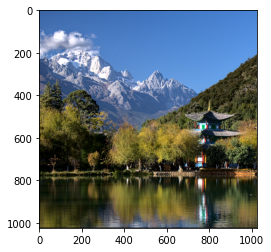

In [4]:
# original image
sample_img_BGR_orig = cv2.imread(_IN_DIR + _IMG_NAME)
sample_img_RGB_orig = cv2.cvtColor(sample_img_BGR_orig, cv2.COLOR_BGR2RGB)

plt.imshow(sample_img_RGB_orig)
plt.show()

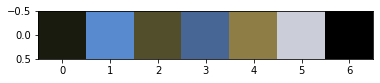

In [5]:
# theme image (kmeans colors)
sample_img_BGR = cv2.imread(_EVAL_THEME_RGB + _IMG_NAME)
sample_img_RGB = cv2.cvtColor(sample_img_BGR, cv2.COLOR_BGR2RGB)

plt.imshow(sample_img_RGB)
plt.show()

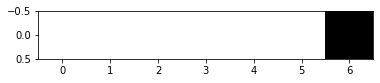

In [6]:
# theme image mask
sample_img_BGR = cv2.imread(_EVAL_MASK + _IMG_NAME)
sample_img_RGB = cv2.cvtColor(sample_img_BGR, cv2.COLOR_BGR2RGB)

plt.imshow(sample_img_RGB)
plt.show()

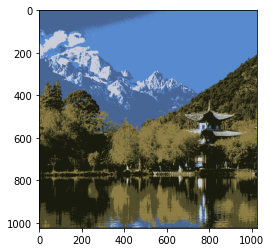

In [7]:
# color map
sample_img_BGR = cv2.imread(_EVAL_COLOR_MAP_DIR + _IMG_NAME)
sample_img_RGB = cv2.cvtColor(sample_img_BGR, cv2.COLOR_BGR2RGB)

plt.imshow(sample_img_RGB)
plt.show()

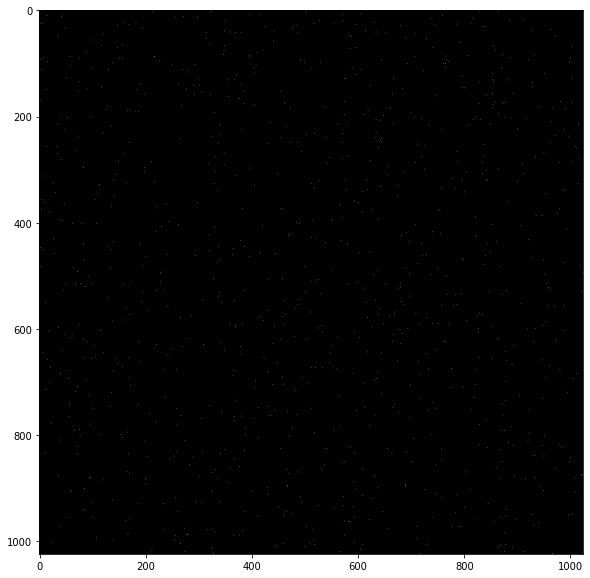

In [8]:
# simulated user inputs (boolean mask)
sample_img_BGR = cv2.imread(_EVAL_POINTS_MASK + _IMG_NAME)
sample_img_RGB = cv2.cvtColor(sample_img_BGR, cv2.COLOR_BGR2RGB)

# increase size, if pixels aren't visible, due to low resolution
plt.figure(figsize = (10,10))

plt.imshow(sample_img_RGB)
plt.show()

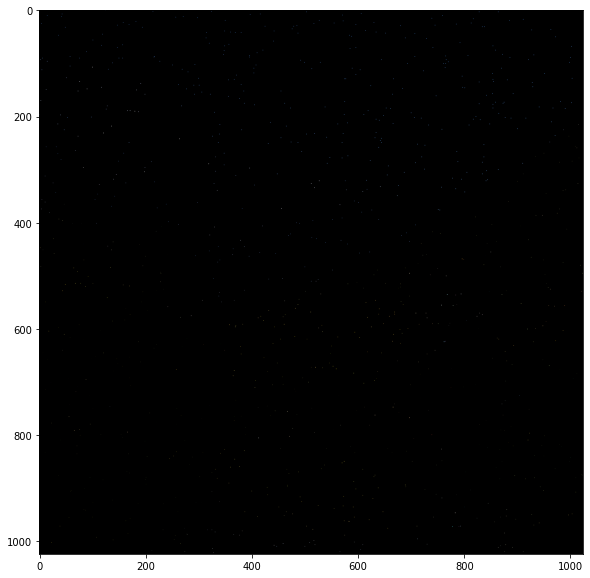

In [9]:
# simulated user colors (RGB)
sample_img_BGR = cv2.imread(_EVAL_POINTS_RGB + _IMG_NAME)
sample_img_RGB = cv2.cvtColor(sample_img_BGR, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (10,10))
plt.imshow(sample_img_RGB)
plt.show()

**Step 3:** Run Colorization Pipeline

In [10]:
_LOGS_DIR = _BASE_PATH + 'res/logs/'
_SAVE_PATH = _BASE_PATH + 'res/eval/'

def eval_colorization():
    capacity = 1000
    img_size_h, img_size_w = (_IMG_SIZE_H, _IMG_SIZE_W)
    batch_size = 1
    save_path = _SAVE_PATH + 'generated_color'
    logs_ckpts_run_3 = _LOGS_DIR + 'run_3/'

    # because of migration from tf 1.x -> 2.x
    tf.compat.v1.disable_eager_execution()
    sess = tf.compat.v1.Session()
    train_list = input_data.get_train_list(
        [_EVAL_IMG_RGB, _EVAL_THEME_RGB, _EVAL_MASK, _EVAL_COLOR_MAP_DIR, _EVAL_POINTS_RGB, _EVAL_POINTS_MASK],
        ['color img', 'theme img', 'theme mask', 'color_map img', 'local img', 'local mask'],
        ['*', '*', 'png', 'png', 'png', 'png'], shuffle=False)

    image_rgb_batch, theme_rgb_batch, theme_mask_batch, index_rgb_batch, point_rgb_batch, point_mask_batch = \
        input_data.get_batch(train_list, (img_size_h, img_size_w), batch_size, capacity, False)

    image_lab_batch = input_data.rgb_to_lab(image_rgb_batch)
    image_l_batch = tf.reshape(image_lab_batch[:, :, :, 0] / 100.0 * 2 - 1, [batch_size, img_size_h, img_size_w, 1])
    image_l_gra_batch = model.sobel(image_l_batch)

    theme_lab_batch = input_data.rgb_to_lab(theme_rgb_batch)
    theme_ab_batch = (theme_lab_batch[:, :, :, 1:] + 128.) / 255.0 * 2 - 1

    point_lab_batch = input_data.rgb_to_lab(point_rgb_batch)
    point_ab_batch = (point_lab_batch[:, :, :, 1:] + 128.) / 255.0 * 2 - 1

    # TODO: colorization
    out_ab_batch = model.inference3_1(image_l_batch, image_l_gra_batch, theme_ab_batch, theme_mask_batch,
                                      point_ab_batch, point_mask_batch,
                                      is_training=False, scope_name='UserGuide')
    # TODO: residual network
    _, out_ab_batch2 = model.gen_PRLNet(out_ab_batch, image_l_batch, 2, scope_name='PRLNet')
    test_rgb_out2 = \
        input_data.lab_to_rgb(
            tf.concat([(image_l_batch + 1.) / 2 * 100., (out_ab_batch2 + 1.) / 2 * 255. - 128], axis=3))

    var_list = tf.compat.v1.global_variables()
    var_model1 = [var for var in var_list if var.name.startswith('UserGuide')]
    var_model2 = [var for var in var_list if var.name.startswith('PRLNet')]
    var_total = var_model1 + var_model2
    paras_count1 = tf.reduce_sum([tf.reduce_prod(v.shape) for v in var_model1])
    paras_count2 = tf.reduce_sum([tf.reduce_prod(v.shape) for v in var_model2])
    print('UserGuide参数数目:%d' % sess.run(paras_count1))
    print('Detailed参数数目:%d' % sess.run(paras_count2))

    saver1 = tf.compat.v1.train.Saver(var_list=var_total)
    print('载入检查点...')
    ckpt = tf.train.get_checkpoint_state(logs_ckpts_run_3)
    if ckpt and ckpt.model_checkpoint_path:
        global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
        saver1.restore(sess, ckpt.model_checkpoint_path)
        print('载入成功, global_step = %s' % global_step)
    else:
        print('载入失败')

    coord = tf.train.Coordinator()
    threads = tf.compat.v1.train.start_queue_runners(sess=sess, coord=coord)
    # compute the average psnr
    avg_psnr = 0.
    avg_ms_ssim = 0.
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    try:
        for t in range(len(train_list[0])):
            in_rgb, out_rgb2 = sess.run([image_rgb_batch, test_rgb_out2])
            in_rgb = in_rgb[0]
            out_rgb2 = out_rgb2[0]
            psnr = peak_signal_noise_ratio(out_rgb2, in_rgb)
            avg_psnr += psnr
            plt.imsave(save_path + '/' + train_list[0][t].split('/')[-1], out_rgb2)
            print('%s\n' % str(psnr))

        print('avg_psnr = %s' % str(avg_psnr / len(train_list[0])))

    except tf.errors.OutOfRangeError:
        print('Done.')
    finally:
        coord.request_stop()

    # Wait for the thread to end
    coord.join(threads=threads)
    sess.close()

In [11]:
eval_colorization()

[Type:color img][File nums: 4, Time_cost: 0.00s]
[Type:theme img][File nums: 4, Time_cost: 0.00s]
[Type:theme mask][File nums: 4, Time_cost: 0.00s]
[Type:color_map img][File nums: 4, Time_cost: 0.00s]
[Type:local img][File nums: 4, Time_cost: 0.00s]
[Type:local mask][File nums: 4, Time_cost: 0.00s]
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(tuple(tensor_list)).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.range(limit).shuffle(limit).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffl

/content/drive/MyDrive/Paper_Sibiu/Interactive-Deep-Colorization-and-Compression-tf/src/colorization/ops.py:52: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  bias_initializer=tf.keras.initializers.glorot_normal())
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:575: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/content/drive/MyDrive/Paper_Sibiu/Interactive-Deep-Colorization-and-Compression-tf/src/colorization/ops.py:73: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  gamma_initializer=tf.compat.v1.random

Tensor("UserGuide/glob_conv3/Relu:0", shape=(1, 1, 1, 512), dtype=float32)
Tensor("UserGuide/glob_conv4/Relu:0", shape=(1, 1, 1, 512), dtype=float32)

LocalBlock
Tensor("UserGuide/ab_conv1_1/Relu:0", shape=(1, 1024, 1024, 64), dtype=float32)
Tensor("UserGuide/bw_conv1_1/Relu:0", shape=(1, 1024, 1024, 64), dtype=float32)
Tensor("UserGuide/gra_conv1_1/Relu:0", shape=(1, 1024, 1024, 64), dtype=float32)

ConvBlock 1
Tensor("UserGuide/conv1_1/Relu:0", shape=(1, 1024, 1024, 64), dtype=float32)
Tensor("UserGuide/conv1_2/Relu:0", shape=(1, 1024, 1024, 64), dtype=float32)
Tensor("UserGuide/conv1_2_ss/depthwise:0", shape=(1, 512, 512, 64), dtype=float32)

ConvBlock 2
Tensor("UserGuide/conv2_1/Relu:0", shape=(1, 512, 512, 128), dtype=float32)
Tensor("UserGuide/conv2_2/Relu:0", shape=(1, 512, 512, 128), dtype=float32)
Tensor("UserGuide/conv2_2_ss/depthwise:0", shape=(1, 256, 256, 128), dtype=float32)

ConvBlock 3
Tensor("UserGuide/conv3_1/Relu:0", shape=(1, 256, 256, 256), dtype=float32)
Tensor("U

**Step 4:** Visualize Reconstruction/ Error Map

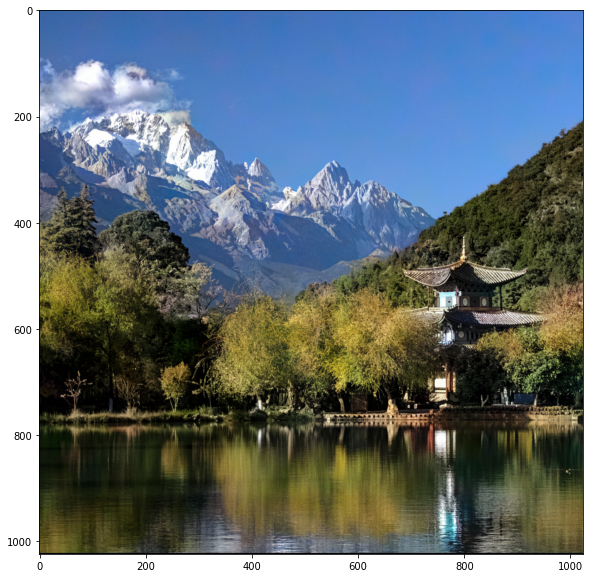

In [12]:
# reconstructed image
sample_img_BGR = cv2.imread(_SAVE_PATH + 'generated_color/' +  _IMG_NAME)
sample_img_RGB = cv2.cvtColor(sample_img_BGR, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (10,10))
plt.imshow(sample_img_RGB)
plt.show()

(1024, 1024)


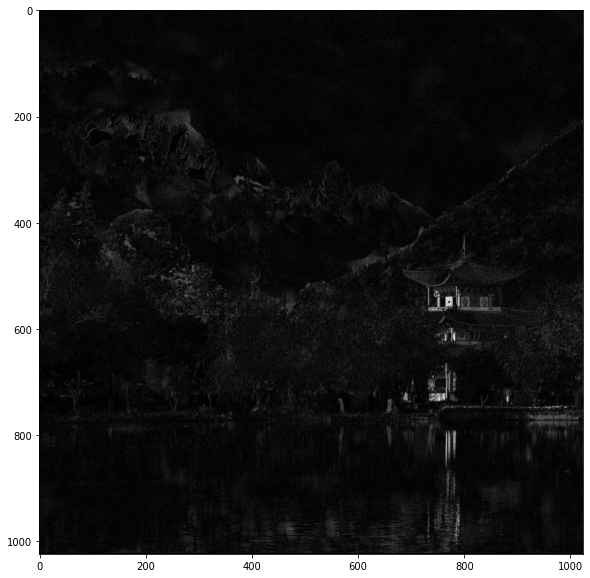

In [13]:
# absolute differences (white spots reveal largest error sections)
sample_img_RGB_orig = tf.cast(sample_img_RGB_orig, tf.float32)
sample_img_RGB = tf.cast(sample_img_RGB, tf.float32)

error_map_RGB = tf.reduce_mean(abs(sample_img_RGB_orig - sample_img_RGB), axis=-1)
tf.compat.v1.train.start_queue_runners
sess = tf.compat.v1.Session().run(error_map_RGB)
# error_map_RGB = tf.Session().run(error_map_RGB)
print(error_map_RGB.shape)

from tensorflow.python.keras import backend
sess = backend.get_session()
error_map_RGB_array = sess.run(error_map_RGB)

plt.figure(figsize = (10,10))
plt.imshow(error_map_RGB_array, cmap='gray')
plt.show()